In [12]:
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d

'''

Enter M in the form (lon, lat, depth, time)

z_r is the depth matrix of all the sigma points
it has form (lon, lat, sigma) after me transposing it,
0 sigma is the surface and 29 sigma is the bottom 

'''

def depth_interpolator(M, z_r, depths):

    # Dimensions of M and z_r
    dim_i, dim_j, dim_sigma, dim_time = M.shape
    assert z_r.shape == (dim_i, dim_j, dim_sigma)

    # Initialize interpolated matrix
    M_interpolated = np.zeros((dim_i, dim_j, len(depths), dim_time))

    # Interpolate for each day (time dimension)
    for t in range(dim_time):
        for i in range(dim_i):
            for j in range(dim_j):
                # Get depth levels from z_r
                depth_levels = z_r[i, j, :]
                
                # Get values of M at each depth level for current time t
                values = M[i, j, :, t]
                
                # Perform interpolation
                if np.all(np.isnan(values)):
                    # Handle case where all values are NaN (e.g., outside valid data range)
                    interpolated_values = np.full(len(depths), np.nan)
                else:
                    # Use linear interpolation
                    interpolator = interp1d(depth_levels, values, kind='linear', bounds_error=False, fill_value=np.nan)
                    interpolated_values = interpolator(depths)
                
                # Assign interpolated values to M_interpolated for current time t
                M_interpolated[i, j, :, t] = interpolated_values
        M_interpolated[:,:, 0, t] = M[:,:,0,t]

    return M_interpolated


# Sample

z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

depths = z_r[150, 150, :] # I use a center(ish) point of the model because I like those depths

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
u_east = dataset.variables['u_eastward']
M = np.transpose(u_east, axes=(3, 2, 1, 0))

M_interpolated = depth_interpolator(M, z_r, depths)



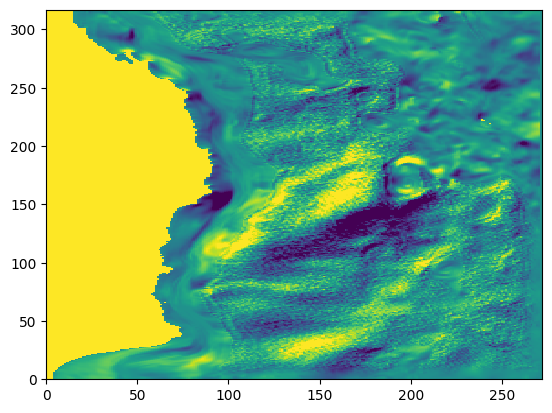

In [33]:
import matplotlib.pyplot as plt

plt.pcolor(M_interpolated[:,:,-29,0].T,vmin=-.2, vmax=.2)